In [1]:
import os
import sys
import cv2

import numpy as np
import pandas as pd
import tensorflow as tf

sys.path.append("../faiss")
import faiss 

from model.utils import Params
from model.model_fn import model_fn
from model.input_fn import raw_dataset

from matplotlib import pyplot as plt
%matplotlib inline  

Failed to load GPU Faiss: No module named swigfaiss_gpu
Faiss falling back to CPU-only.


In [2]:
model_dir = "experiments/mnist-mobilenet/"

json_path = os.path.join(model_dir, 'params.json')
assert os.path.isfile(json_path), "No json configuration file found at {}".format(json_path)
params = Params(json_path)

dataset_dir = os.path.join("data", params.dataset)
export_dir = os.path.join(model_dir, "export/1523234727")
embeddings_file="mnist_mobilenet_embeddings.csv"
dataset_size = params.train_size + params.validate_size
print(dataset_dir)

data/mnist-as-jpeg


In [3]:
LABELS_FILENAME = 'labels.txt'

def normalize_image(image):
    return (image - np.mean(image)) / np.maximum(np.std(image), 1.0/np.sqrt(image.size))

def read_label_file(dataset_dir, filename=LABELS_FILENAME):
    labels_filename = os.path.join(dataset_dir, filename)
    with tf.gfile.Open(labels_filename, 'r') as f:
        lines = f.read().decode()
    lines = lines.split('\n')
    lines = filter(None, lines)

    labels_to_class_names = {}
    for line in lines:
        index = line.index(':')
        labels_to_class_names[int(line[:index])] = line[index+1:]
        
    return labels_to_class_names

In [4]:
labels_to_class_names = read_label_file(dataset_dir)

INFO:tensorflow:Extracting the dataset...
42000
(42000, 128, 128, 3)
(42000, 128, 128, 3)
(42000,)


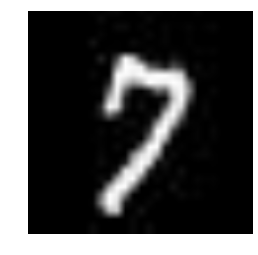

In [5]:
tf.reset_default_graph()
tf.logging.set_verbosity(tf.logging.INFO)

# Create the input data pipeline
tf.logging.info("Extracting the dataset...")
data_filenames = []
data_filenames.append(os.path.join(dataset_dir, 'train.tfrecord'))
data_filenames.append(os.path.join(dataset_dir, 'validation.tfrecord'))

# Create the two input functions over the two datasets
validate_input_fn = lambda: raw_dataset(include_raw_image=True, data_filenames=data_filenames, params=params)

# A bit wasteful with memory having both raw and normalized image at once... revisit this.
test_index = 0
test_images = np.zeros((dataset_size, params.image_size, params.image_size, 3), dtype=np.uint8)
test_normalized_images = np.zeros((dataset_size, params.image_size, params.image_size, 3), dtype=np.float32)
test_labels = np.zeros((dataset_size), dtype=np.int)

with tf.Session() as sess:
    iterator = validate_input_fn().make_one_shot_iterator()
    next_element = iterator.get_next()

    while True:
        try:
            image, image_normalized, label = sess.run(next_element)
            
            for batchIx in range(image.shape[0]):
                test_images[test_index] = image[batchIx]
                test_normalized_images[test_index] = image_normalized[batchIx]
                test_labels[test_index] = label[batchIx]
                test_index+=1
                
        except tf.errors.OutOfRangeError:
            break

print(test_index)
print(test_images.shape)
print(test_normalized_images.shape)
print(test_labels.shape)

index=0
plt.figure()
plt.imshow(test_images[index])
plt.axis('off')
plt.show()

In [6]:
faiss_identities = []
faiss_index = faiss.IndexFlatL2(params.embedding_size)

input_tensor = "images:0"
output_tensor = "model/embeddings/BiasAdd:0"

with tf.Session(graph=tf.Graph()) as sess:    
    tf.saved_model.loader.load(sess, ["serve"], export_dir)    
    
    #for op in tf.get_default_graph().get_operations():
    #    print str(op.name) 
    for index in range(dataset_size):  
        image_data = np.expand_dims(normalize_image(test_images[index]), axis=0)
        embedding =sess.run(output_tensor, feed_dict={input_tensor:image_data})
                
        if test_labels[index] >= params.num_labels:
            identity = "general"
        else:
            identity = labels_to_class_names[test_labels[index]]
            
        faiss_index.add(embedding)
        faiss_identities.append(identity)
        
        df1 = pd.DataFrame([identity], columns=["id"])
        df2 = pd.DataFrame(embedding)
        row = pd.concat([df1, df2], axis=1)

        if (index is 0):
            df = row
        else:
            df = df.append(row)
            
    df.to_csv(embeddings_file, index=False)
    
print (faiss_index.ntotal)

INFO:tensorflow:Restoring parameters from experiments/mnist-mobilenet/export/1523234727/variables/variables
42000


In [7]:
def predict (image):
    image_data = np.expand_dims(normalize_image(image), axis=0)

    plt.figure()
    plt.imshow(image)
    plt.axis('off')
    plt.show()

    input_tensor = "images:0"
    output_tensor = "model/embeddings/BiasAdd:0"

    with tf.Session(graph=tf.Graph()) as sess:    
        tf.saved_model.loader.load(sess, ["serve"], export_dir)    

        #for op in tf.get_default_graph().get_operations():
        #    print str(op.name) 
        embedding =sess.run(output_tensor, feed_dict={input_tensor:image_data})

    distances, indicies = faiss_index.search(embedding, 10)

    print(distances)
    print(faiss_identities[indicies[0,0]])
    print(faiss_identities[indicies[0,1]])
    print(faiss_identities[indicies[0,2]])
    print(faiss_identities[indicies[0,3]])
    print(faiss_identities[indicies[0,4]])
    print(faiss_identities[indicies[0,5]])
    print(faiss_identities[indicies[0,6]])
    print(faiss_identities[indicies[0,7]])
    print(faiss_identities[indicies[0,8]])
    print(faiss_identities[indicies[0,9]])

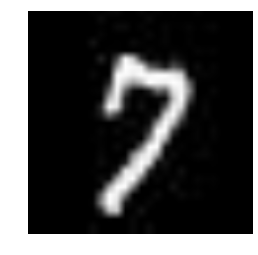

INFO:tensorflow:Restoring parameters from experiments/mnist-mobilenet/export/1523234727/variables/variables
[[0.0000000e+00 2.0898420e-18 2.4970531e-18 2.6632833e-18 2.6952588e-18
  2.8019850e-18 2.8106671e-18 2.8877471e-18 2.9620742e-18 2.9707563e-18]]
7
4
0
8
7
7
3
4
6
4


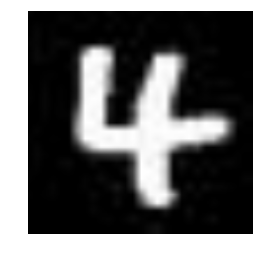

INFO:tensorflow:Restoring parameters from experiments/mnist-mobilenet/export/1523234727/variables/variables
[[0.0000000e+00 1.6375264e-18 1.6449380e-18 1.7230768e-18 1.8355204e-18
  1.9602460e-18 1.9973037e-18 2.0413494e-18 2.0447375e-18 2.2651779e-18]]
4
6
1
1
9
0
3
0
7
4


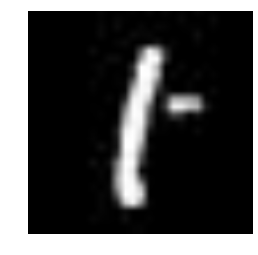

INFO:tensorflow:Restoring parameters from experiments/mnist-mobilenet/export/1523234727/variables/variables
[[0.0000000e+00 3.0537655e-18 3.0918820e-18 3.1924672e-18 3.2661590e-18
  3.2960170e-18 3.3008874e-18 3.3976609e-18 3.4357774e-18 3.4558944e-18]]
1
4
9
8
4
2
7
5
1
3


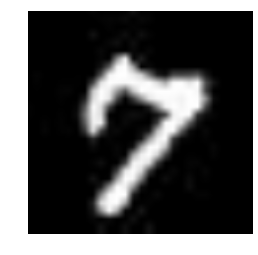

INFO:tensorflow:Restoring parameters from experiments/mnist-mobilenet/export/1523234727/variables/variables
[[0.0000000e+00 2.8714417e-18 2.9654623e-18 3.1698090e-18 3.1967023e-18
  3.2229604e-18 3.2356659e-18 3.2415951e-18 3.3576386e-18 3.4474241e-18]]
7
7
6
3
0
4
4
0
7
1


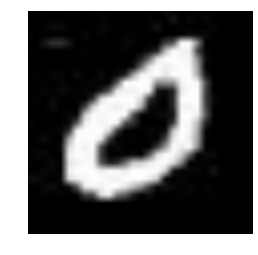

INFO:tensorflow:Restoring parameters from experiments/mnist-mobilenet/export/1523234727/variables/variables
[[0.0000000e+00 1.3798167e-18 1.5924219e-18 2.0000565e-18 2.1491343e-18
  2.1499814e-18 2.1694631e-18 2.2234615e-18 2.2431550e-18 2.2471784e-18]]
0
3
1
7
3
7
7
4
5
0


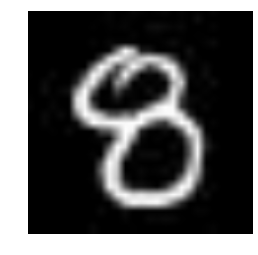

INFO:tensorflow:Restoring parameters from experiments/mnist-mobilenet/export/1523234727/variables/variables
[[0.0000000e+00 1.5119538e-18 1.7423468e-18 2.0169972e-18 2.0627370e-18
  2.0813717e-18 2.1353701e-18 2.1931801e-18 2.2067326e-18 2.2406139e-18]]
8
7
2
1
7
7
7
1
2
8


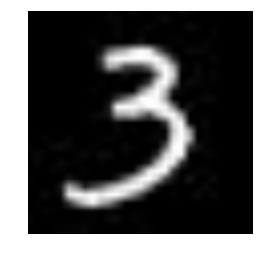

INFO:tensorflow:Restoring parameters from experiments/mnist-mobilenet/export/1523234727/variables/variables
[[0.0000000e+00 2.1067827e-18 2.2118148e-18 2.6977999e-18 2.7147406e-18
  2.7285049e-18 2.8265489e-18 2.8606420e-18 2.8765239e-18 2.9123110e-18]]
3
4
9
6
8
3
7
3
8
2


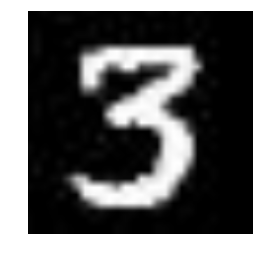

INFO:tensorflow:Restoring parameters from experiments/mnist-mobilenet/export/1523234727/variables/variables
[[0.0000000e+00 3.0467775e-18 3.2458303e-18 3.3127459e-18 3.4315422e-18
  3.4611884e-18 3.5153985e-18 3.5211160e-18 3.5236571e-18 3.6397006e-18]]
3
7
2
5
1
2
0
2
7
2


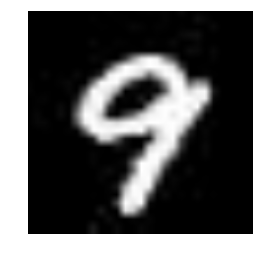

INFO:tensorflow:Restoring parameters from experiments/mnist-mobilenet/export/1523234727/variables/variables
[[0.0000000e+00 2.5385577e-18 2.9444983e-18 2.9944732e-18 3.0334367e-18
  3.0577889e-18 3.1071286e-18 3.2231721e-18 3.2248662e-18 3.2331248e-18]]
9
5
0
6
5
0
0
6
3
6


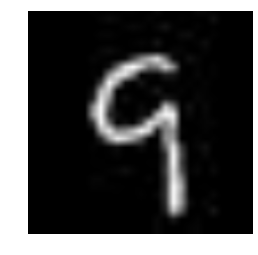

INFO:tensorflow:Restoring parameters from experiments/mnist-mobilenet/export/1523234727/variables/variables
[[0.0000000e+00 1.9413995e-18 2.0864539e-18 2.1717925e-18 2.2099090e-18
  2.3287053e-18 2.4741832e-18 2.4970531e-18 2.4979002e-18 2.5554984e-18]]
9
9
0
8
1
2
7
1
6
0


In [8]:
for index in range(10):
    predict(test_images[index+0])

In [ ]:
def evaluate_test_set(testset_dir, start_count, max_count):
    count=0
    for filename in os.listdir(testset_dir):
        if filename.endswith(".jpg"):
            count += 1
            
            if (count < start_count):
                continue
            
            image_file = os.path.join(testset_dir, filename)
            image = cv2.imread(image_file)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
            predict (image)
            
            if (count > start_count + max_count):
                break
        else:
            continue

In [ ]:
testset_dir = os.path.join(dataset_dir, "testSet") # mnist
evaluate_test_set(testset_dir, 0, 10)

In [ ]:
def load_embeddings_file(embeddings_file):
    df = pd.read_csv(embeddings_file)

    faiss_identities = []
    faiss_index = faiss.IndexFlatL2(params.embedding_size)

    for _, row in df.iterrows():
        identity = row['id']
        embedding = row.iloc[1:params.embedding_size+1].as_matrix().astype('float32')
        embedding = np.ascontiguousarray(embedding.reshape(1, params.embedding_size))
        faiss_index.add(embedding)
        faiss_identities.append(identity)